In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [3]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

In [4]:
import gymnasium as gym

In [5]:
!pip install numpy==1.23.5
# questa cella va prima della parte dell'algoritmo migliorato

In [8]:
import csv
import os
import time
import matplotlib.pyplot as plt
import gym
import numpy as np


In [26]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from collections import deque, namedtuple
import random


# Parte migliorata

In [6]:


env = gym.make("LunarLanderContinuous-v2")

print("=== ENV INFO ===")
print("Env ID:", env.spec.id)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Action dtype:", env.action_space.dtype)
print("Action low:", env.action_space.low)
print("Action high:", env.action_space.high)
print()

# Reset test
try:
    obs, info = env.reset()
    print("Reset returns: obs, info")
except:
    obs = env.reset()
    print("Reset returns: only obs")

print("Observation shape:", obs.shape)
print("Observation dtype:", obs.dtype)
print()

# Step test
dummy_action = np.array([0.0, 0.0], dtype=np.float32)
print("Dummy action to test step():", dummy_action, " | dtype:", dummy_action.dtype, " | shape:", dummy_action.shape)

try:
    result = env.step(dummy_action)
    print("Step returns:", len(result), "values")
    print("Step output types:", [type(x) for x in result])
except Exception as e:
    print("Step() ERROR:", e)


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/

=== ENV INFO ===
Env ID: LunarLanderContinuous-v2
Observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)
Action dtype: float32
Action low: [-1. -1.]
Action high: [1. 1.]

Reset returns: only obs
Observation shape: (8,)
Observation dtype: float32

Dummy action to test step(): [0. 0.]  | dtype: float32  | shape: (2,)
Step returns: 4 values
Step output types: [<class 'numpy.ndarray'>, <class 'numpy.float64'>, <class 'bool'>, <class 'dict'>]


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Cella contenente tutto il modello SAC

In [ ]:
#===================================================================
#               PRIMA VERSIONE SAC
#===================================================================

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from collections import deque, namedtuple
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reti
class SoftQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, log_std_min=-20, log_std_max=2):
        super().__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean_layer = nn.Linear(hidden_dim, action_dim)
        self.log_std_layer = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean_layer(x)
        log_std = torch.clamp(self.log_std_layer(x), self.log_std_min, self.log_std_max)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()
        action = torch.tanh(x_t)
        log_prob = normal.log_prob(x_t) - torch.log(1 - action.pow(2) + 1e-6)
        return action, log_prob.sum(dim=1, keepdim=True)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=1e6):
        self.buffer = deque(maxlen=int(capacity))
        self.experience = namedtuple("Exp", field_names=["s", "a", "r", "s2", "d"])

    def add(self, s, a, r, s2, d):
        s = np.array(s, dtype=np.float32)
        a = np.array(a, dtype=np.float32)
        s2 = np.array(s2, dtype=np.float32)
        r = float(r)
        d = bool(d)
        self.buffer.append(self.experience(s, a, r, s2, d))
""" faccio upgrade:
    def sample(self, batch_size):
        exps = random.sample(self.buffer, batch_size)
        s = torch.FloatTensor([e.s for e in exps]).to(device)
        a = torch.FloatTensor([e.a for e in exps]).to(device)
        r = torch.FloatTensor([[e.r] for e in exps]).to(device)
        s2 = torch.FloatTensor([e.s2 for e in exps]).to(device)
        d = torch.FloatTensor([[float(e.d)] for e in exps]).to(device)
        return s, a, r, s2, d

"""
    def sample(self, batch_size):
      exps = random.sample(self.buffer, batch_size)

      # Conversione efficiente con np.array
      s = torch.FloatTensor(np.array([e.s for e in exps])).to(device)
      a = torch.FloatTensor(np.array([e.a for e in exps])).to(device)
      r = torch.FloatTensor(np.array([[e.r] for e in exps])).to(device)
      s2 = torch.FloatTensor(np.array([e.s2 for e in exps])).to(device)
      d = torch.FloatTensor(np.array([[float(e.d)] for e in exps])).to(device)

      return s, a, r, s2, d

    def __len__(self):
        return len(self.buffer)


# SAC Agent
class SACAgent:
    def __init__(self, state_dim, action_dim, action_bounds, gamma=0.99, tau=0.005, alpha=0.2, lr=3e-4):
        self.action_low, self.action_high = action_bounds
        self.q1 = SoftQNetwork(state_dim, action_dim).to(device)
        self.q2 = SoftQNetwork(state_dim, action_dim).to(device)
        self.q1_target = SoftQNetwork(state_dim, action_dim).to(device)
        self.q2_target = SoftQNetwork(state_dim, action_dim).to(device)
        self.policy = PolicyNetwork(state_dim, action_dim).to(device)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.q1_opt = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_opt = optim.Adam(self.q2.parameters(), lr=lr)
        self.policy_opt = optim.Adam(self.policy.parameters(), lr=lr)

        self.gamma = gamma
        self.tau = tau
        self.target_entropy = -action_dim
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha = self.log_alpha.exp()
        self.alpha_opt = optim.Adam([self.log_alpha], lr=lr)

        self.replay_buffer = ReplayBuffer()

    def act(self, state, deterministic=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            mean, log_std = self.policy(state)
            std = log_std.exp()
            if deterministic:
                action = torch.tanh(mean)
            else:
                normal = Normal(mean, std)
                x_t = normal.sample()
                action = torch.tanh(x_t)
        action = action.cpu().numpy()[0]
        scaled = action * (self.action_high - self.action_low) / 2 + (self.action_high + self.action_low) / 2
        return scaled.astype(np.float32)

    def update(self, batch_size=256):
        if len(self.replay_buffer) < batch_size:
            return
        s, a, r, s2, d = self.replay_buffer.sample(batch_size)

        with torch.no_grad():
            a2, logp2 = self.policy.sample(s2)
            q1_t = self.q1_target(s2, a2)
            q2_t = self.q2_target(s2, a2)
            q_target = torch.min(q1_t, q2_t) - self.alpha * logp2
            y = r + (1 - d) * self.gamma * q_target

        q1 = self.q1(s, a)
        q2 = self.q2(s, a)
        q1_loss = F.mse_loss(q1, y)
        q2_loss = F.mse_loss(q2, y)

        self.q1_opt.zero_grad(); q1_loss.backward(); self.q1_opt.step()
        self.q2_opt.zero_grad(); q2_loss.backward(); self.q2_opt.step()

        a_new, logp_new = self.policy.sample(s)
        q1_pi = self.q1(s, a_new)
        q2_pi = self.q2(s, a_new)
        q_pi = torch.min(q1_pi, q2_pi)
        policy_loss = (self.alpha * logp_new - q_pi).mean()

        self.policy_opt.zero_grad(); policy_loss.backward(); self.policy_opt.step()

        alpha_loss = -(self.log_alpha * (logp_new + self.target_entropy).detach()).mean()
        self.alpha_opt.zero_grad(); alpha_loss.backward(); self.alpha_opt.step()
        self.alpha = self.log_alpha.exp()  # aggiorna alpha dinamicamente

        for t, l in zip(self.q1_target.parameters(), self.q1.parameters()):
            t.data.copy_(self.tau * l.data + (1 - self.tau) * t.data)
        for t, l in zip(self.q2_target.parameters(), self.q2.parameters()):
            t.data.copy_(self.tau * l.data + (1 - self.tau) * t.data)


IndentationError: unexpected indent (ipython-input-2-2937990807.py, line 76)

Parte del traning Loop primo modello

In [ ]:


env = gym.make("LunarLanderContinuous-v2")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
action_bounds = (env.action_space.low, env.action_space.high)

agent = SACAgent(obs_dim, act_dim, action_bounds)

num_episodes = 500
max_steps = 1000
batch_size = 256
rewards_log = []

# Setup CSV
csv_filename = "rewards.csv"
if os.path.exists(csv_filename):
    os.remove(csv_filename)
with open(csv_filename, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Episode", "TotalReward"])

# Training loop
for ep in range(1, num_episodes + 1):
    try:
        state, _ = env.reset()
    except:
        state = env.reset()

    total_reward = 0
    for t in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)  #  4 valori corretti

        agent.replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.update(batch_size)
        if done:
            break

    rewards_log.append(total_reward)
    with open(csv_filename, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([ep, total_reward])

    if ep % 10 == 0:
        avg_reward = np.mean(rewards_log[-10:])
        print(f"Episode {ep}/{num_episodes} | Avg Reward (last 10): {avg_reward:.2f}")

# Plot (opzionale)
plt.plot(rewards_log)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("SAC Training Reward")
plt.grid(True)
plt.show()


In [ ]:


# Parametri multipli run
num_runs = 5
num_episodes = 1500
max_steps = 1000
batch_size = 256
save_dir = "/mnt/data/sac_runs"
os.makedirs(save_dir, exist_ok=True)

# Per ogni run
for run in range(1, num_runs + 1):
    print(f"\n=== Inizio Run {run}/{num_runs} ===")
    env = gym.make("LunarLanderContinuous-v2")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    action_bounds = (env.action_space.low, env.action_space.high)

    agent = SACAgent(obs_dim, act_dim, action_bounds)

    rewards_log = []

    # File CSV per questa run
    csv_path = os.path.join(save_dir, f"rewards_run_{run}.csv")
    with open(csv_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Episode", "TotalReward"])

    for ep in range(1, num_episodes + 1):
        # Seed variabile per ogni run/episodio
        try:
            state, _ = env.reset(seed=run * 100 + ep)
        except:
            state = env.reset()

        total_reward = 0
        for t in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.update(batch_size)
            if done:
                break

        rewards_log.append(total_reward)
        with open(csv_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([ep, total_reward])

        # Log ogni 100 episodi
        if ep % 100 == 0:
            avg_reward = np.mean(rewards_log[-100:])
            print(f"Run {run} | Episode {ep}/{num_episodes} | Avg Reward (last 100): {avg_reward:.2f}")

    env.close()

print(f"\n Tutte le {num_runs} run completate. I file CSV sono salvati in:\n{save_dir}")


In [ ]:
# =========================================
#               terzo modello migliore
# ==========================================

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from collections import deque, namedtuple
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- RETI ---
class SoftQNetwork(nn.Module):
    """Critic Q-function: Q(s, a)"""
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.net(x)

class PolicyNetwork(nn.Module):
    """Stochastic policy π(a|s) using reparameterization trick"""
    def __init__(self, state_dim, action_dim, hidden_dim=256, log_std_min=-20, log_std_max=2):
        super().__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.mean_layer = nn.Linear(hidden_dim, action_dim)
        self.log_std_layer = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = self.net(state)
        mean = self.mean_layer(x)
        log_std = torch.clamp(self.log_std_layer(x), self.log_std_min, self.log_std_max)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()  # reparam trick
        action = torch.tanh(x_t)
        log_prob = normal.log_prob(x_t) - torch.log(1 - action.pow(2) + 1e-6)
        return action, log_prob.sum(dim=1, keepdim=True)

# --- REPLAY BUFFER ---
class ReplayBuffer:
    def __init__(self, capacity=1e6):
        self.buffer = deque(maxlen=int(capacity))
        self.experience = namedtuple("Exp", field_names=["s", "a", "r", "s2", "d"])

    def add(self, s, a, r, s2, d):
        self.buffer.append(self.experience(
            np.array(s, dtype=np.float32),
            np.array(a, dtype=np.float32),
            float(r),
            np.array(s2, dtype=np.float32),
            bool(d)
        ))

    def sample(self, batch_size):
        exps = random.sample(self.buffer, batch_size)
        # efficient conversion (solves Colab warning)
        s = torch.tensor(np.array([e.s for e in exps]), dtype=torch.float32, device=device)
        a = torch.tensor(np.array([e.a for e in exps]), dtype=torch.float32, device=device)
        r = torch.tensor(np.array([[e.r] for e in exps]), dtype=torch.float32, device=device)
        s2 = torch.tensor(np.array([e.s2 for e in exps]), dtype=torch.float32, device=device)
        d = torch.tensor(np.array([[float(e.d)] for e in exps]), dtype=torch.float32, device=device)
        return s, a, r, s2, d

    def __len__(self):
        return len(self.buffer)

# --- AGENTE SAC ---
class SACAgent:
    def __init__(self, state_dim, action_dim, action_bounds, gamma=0.99, tau=0.005, alpha=0.2, lr=3e-4):
        self.action_low, self.action_high = action_bounds

        self.q1 = SoftQNetwork(state_dim, action_dim).to(device)
        self.q2 = SoftQNetwork(state_dim, action_dim).to(device)
        self.q1_target = SoftQNetwork(state_dim, action_dim).to(device)
        self.q2_target = SoftQNetwork(state_dim, action_dim).to(device)
        self.policy = PolicyNetwork(state_dim, action_dim).to(device)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.q1_opt = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_opt = optim.Adam(self.q2.parameters(), lr=lr)
        self.policy_opt = optim.Adam(self.policy.parameters(), lr=lr)

        self.gamma = gamma
        self.tau = tau
        self.target_entropy = -action_dim
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_opt = optim.Adam([self.log_alpha], lr=lr)
        self.alpha = self.log_alpha.exp()

        self.replay_buffer = ReplayBuffer()

    def act(self, state, deterministic=False):
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            mean, log_std = self.policy(state)
            std = log_std.exp()
            action = torch.tanh(mean if deterministic else Normal(mean, std).sample())
        action = action.cpu().numpy()[0]
        # Rescale from [-1,1] to original env bounds
        return ((action + 1) / 2 * (self.action_high - self.action_low) + self.action_low).astype(np.float32)

    def update(self, batch_size=256):
        if len(self.replay_buffer) < batch_size:
            return

        s, a, r, s2, d = self.replay_buffer.sample(batch_size)

        with torch.no_grad():
            a2, logp2 = self.policy.sample(s2)
            q1_t = self.q1_target(s2, a2)
            q2_t = self.q2_target(s2, a2)
            q_target = torch.min(q1_t, q2_t) - self.alpha * logp2
            y = r + (1 - d) * self.gamma * q_target

        q1 = self.q1(s, a)
        q2 = self.q2(s, a)
        q1_loss = F.mse_loss(q1, y)
        q2_loss = F.mse_loss(q2, y)

        self.q1_opt.zero_grad(); q1_loss.backward(); self.q1_opt.step()
        self.q2_opt.zero_grad(); q2_loss.backward(); self.q2_opt.step()

        a_new, logp_new = self.policy.sample(s)
        q_pi = torch.min(self.q1(s, a_new), self.q2(s, a_new))
        policy_loss = (self.alpha * logp_new - q_pi).mean()

        self.policy_opt.zero_grad(); policy_loss.backward(); self.policy_opt.step()

        alpha_loss = -(self.log_alpha * (logp_new + self.target_entropy).detach()).mean()
        self.alpha_opt.zero_grad(); alpha_loss.backward(); self.alpha_opt.step()
        self.alpha = self.log_alpha.exp()

        # Soft update
        for t, l in zip(self.q1_target.parameters(), self.q1.parameters()):
            t.data.copy_(self.tau * l.data + (1 - self.tau) * t.data)
        for t, l in zip(self.q2_target.parameters(), self.q2.parameters()):
            t.data.copy_(self.tau * l.data + (1 - self.tau) * t.data)


ImportError: cannot import name 'nn' from partially initialized module 'torch' (most likely due to a circular import) (/usr/local/lib/python3.11/dist-packages/torch/__init__.py)

In [ ]:
#anche questa

env = gym.make("LunarLanderContinuous-v2")
obs_dim = env.observation_space.shape[0]
act_dim = env.observation_space.shape[0]
action_bounds = (env.action_space.low, env.action_space.high)

agent = SACAgent(obs_dim, act_dim, action_bounds)

num_episodes = 500
max_steps = 1000
batch_size = 256
rewards_log = []
times_log = []

# Setup CSV
csv_filename = "/mnt/data/rewards_with_time.csv"
if os.path.exists(csv_filename):
    os.remove(csv_filename)
with open(csv_filename, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Episode", "TotalReward", "TimePerEpisode(s)", "CumulativeTime(s)"])

start_training = time.time()

# Training loop
for ep in range(1, num_episodes + 1):
    try:
        state, _ = env.reset()
    except:
        state = env.reset()

    ep_start = time.time()
    total_reward = 0

    for t in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)

        agent.replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.update(batch_size)
        if done:
            break

    ep_time = time.time() - ep_start
    cumulative_time = time.time() - start_training

    rewards_log.append(total_reward)
    times_log.append(ep_time)

    with open(csv_filename, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([ep, total_reward, round(ep_time, 2), round(cumulative_time, 2)])

    if ep % 10 == 0:
        avg_reward = np.mean(rewards_log[-10:])
        print(f"Episode {ep}/{num_episodes} | Avg Reward (last 10): {avg_reward:.2f} | Time per episode: {ep_time:.2f}s")

# Plot (opzionale)
plt.plot(rewards_log)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("SAC Training Reward")
plt.grid(True)
plt.show()


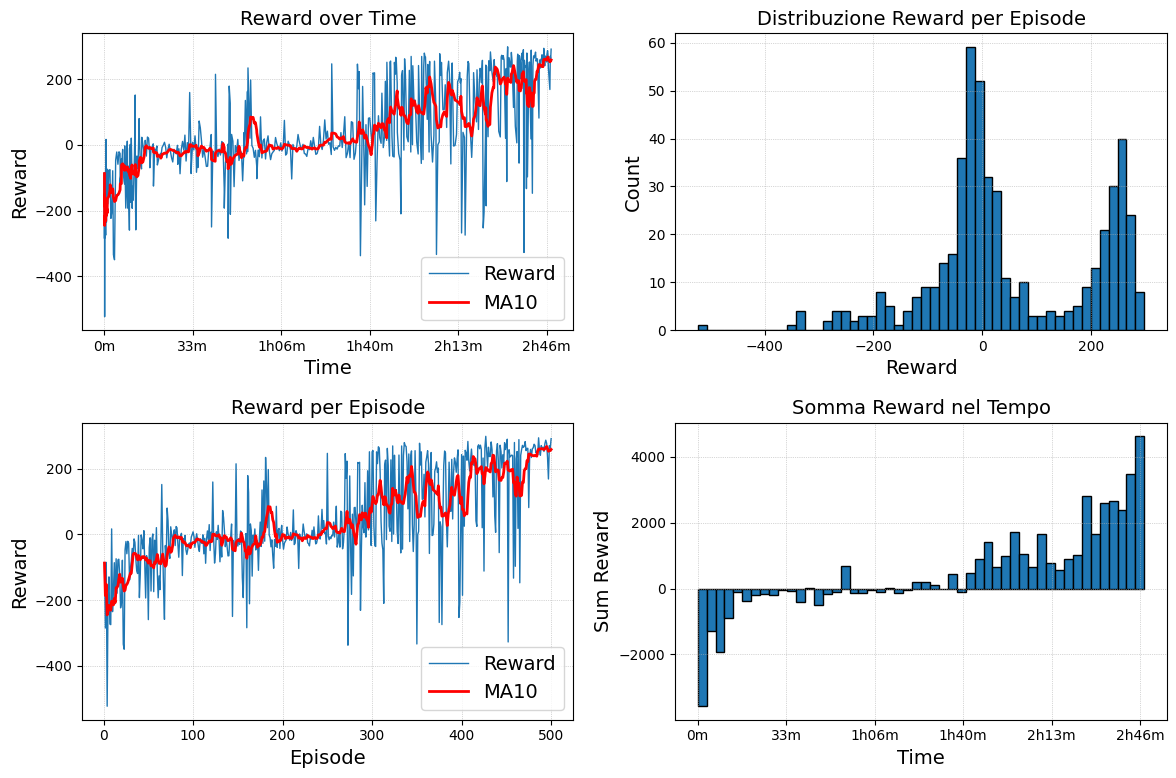

In [29]:

%matplotlib inline

#  Carico il CSV
df = pd.read_csv('/content/rewards_with_time.csv')

#  Rinomino le colonne
df = df.rename(columns={
    'Episode': 'epoch',
    'TotalReward': 'reward',
    'CumulativeTime(s)': 'time_sec'
})
df['time_sec'] = df['time_sec'].astype(float)

# Calcolo la media mobile
window = 10
df['ma'] = df['reward'].rolling(window=window, min_periods=1).mean()

# Formatto per asse tempo (sec -> Xm o HhMMm)
def format_time(x, pos):
    h = int(x // 3600)
    m = int((x % 3600) // 60)
    return f"{h}h{m:02d}m" if h else f"{m}m"

#  Impostao la  figura 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


axs[0,0].plot(df['time_sec'], df['reward'], lw=1, label='Reward')
axs[0,0].plot(df['time_sec'], df['ma'],     lw=2, color='red', label=f'MA{window}')
axs[0,0].set_title('Reward over Time')
axs[0,0].set_xlabel('Time')
axs[0,0].set_ylabel('Reward')
axs[0,0].xaxis.set_major_formatter(FuncFormatter(format_time))
axs[0,0].legend()
axs[0,0].grid(True, linestyle=':', linewidth=0.5)

# Reward per Episodi + MA
axs[1,0].plot(df['epoch'], df['reward'], lw=1, label='Reward')
axs[1,0].plot(df['epoch'], df['ma'],     lw=2, color='red', label=f'MA{window}')
axs[1,0].set_title('Reward per Episode')
axs[1,0].set_xlabel('Episode')
axs[1,0].set_ylabel('Reward')
axs[1,0].legend()
axs[1,0].grid(True, linestyle=':', linewidth=0.5)

#  Istogramma: distribuzione ricompense per episodio
n_bins = 50
axs[0,1].hist(df['reward'], bins=n_bins, edgecolor='black')
axs[0,1].set_title('Distribuzione Reward per Episode')
axs[0,1].set_xlabel('Reward')
axs[0,1].set_ylabel('Count')
axs[0,1].grid(True, linestyle=':', linewidth=0.5)

#  Bar‑plot: somma reward per time‑bin
time = df['time_sec'].values
reward = df['reward'].values
bins = np.linspace(time.min(), time.max(), n_bins+1)
centers = 0.5*(bins[:-1] + bins[1:])
sum_reward = np.array([
    reward[(time>=bins[i]) & (time<bins[i+1])].sum()
    for i in range(n_bins)
])
axs[1,1].bar(centers, sum_reward, width=(bins[1]-bins[0]), edgecolor='black')
axs[1,1].set_title('Somma Reward nel Tempo')
axs[1,1].set_xlabel('Time')
axs[1,1].set_ylabel('Sum Reward')
axs[1,1].xaxis.set_major_formatter(FuncFormatter(format_time))
axs[1,1].grid(True, linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()


NB: dai 300 episodi c'è troppo rumore

# Provo una nuova implementazione con decadimento dell'entropia (non converge bene )

In [ ]:
# ==============================================
# seconda parte codice --UPGRADE (decadimento manuale entropia)
# ==============================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from torch.distributions import Normal
from collections import deque, namedtuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RETI
class SoftQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.net(x)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, log_std_min=-20, log_std_max=2):
        super().__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.mean_layer = nn.Linear(hidden_dim, action_dim)
        self.log_std_layer = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = self.net(state)
        mean = self.mean_layer(x)
        log_std = torch.clamp(self.log_std_layer(x), self.log_std_min, self.log_std_max)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()
        action = torch.tanh(x_t)
        log_prob = normal.log_prob(x_t) - torch.log(1 - action.pow(2) + 1e-6)
        return action, log_prob.sum(dim=1, keepdim=True)

#  REPLAY BUFFER ---
class ReplayBuffer:
    def __init__(self, capacity=1e6):
        self.buffer = deque(maxlen=int(capacity))
        self.experience = namedtuple("Exp", field_names=["s", "a", "r", "s2", "d"])

    def add(self, s, a, r, s2, d):
        self.buffer.append(self.experience(
            np.array(s, dtype=np.float32),
            np.array(a, dtype=np.float32),
            float(r),
            np.array(s2, dtype=np.float32),
            bool(d)
        ))

    def sample(self, batch_size):
        exps = random.sample(self.buffer, batch_size)
        s = torch.tensor(np.array([e.s for e in exps]), dtype=torch.float32, device=device)
        a = torch.tensor(np.array([e.a for e in exps]), dtype=torch.float32, device=device)
        r = torch.tensor(np.array([[e.r] for e in exps]), dtype=torch.float32, device=device)
        s2 = torch.tensor(np.array([e.s2 for e in exps]), dtype=torch.float32, device=device)
        d = torch.tensor(np.array([[float(e.d)] for e in exps]), dtype=torch.float32, device=device)
        return s, a, r, s2, d

    def __len__(self):
        return len(self.buffer)

# SAC AGENT CON TARGET ENTROPY DECAY ---
class SACAgent:
    def __init__(self, state_dim, action_dim, action_bounds, gamma=0.99, tau=0.005, alpha=0.2, lr=3e-4):
        self.action_low, self.action_high = action_bounds

        self.q1 = SoftQNetwork(state_dim, action_dim).to(device)
        self.q2 = SoftQNetwork(state_dim, action_dim).to(device)
        self.q1_target = SoftQNetwork(state_dim, action_dim).to(device)
        self.q2_target = SoftQNetwork(state_dim, action_dim).to(device)
        self.policy = PolicyNetwork(state_dim, action_dim).to(device)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.q1_opt = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_opt = optim.Adam(self.q2.parameters(), lr=lr)
        self.policy_opt = optim.Adam(self.policy.parameters(), lr=lr)

        self.gamma = gamma
        self.tau = tau

        # Entropia automatica e decrescente
        self.initial_target_entropy = -action_dim
        self.final_target_entropy = -0.1 * action_dim
        self.entropy_decay_start = 300
        self.entropy_decay_duration = 500
        self.total_episodes = 0
        self.target_entropy = self.initial_target_entropy

        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_opt = optim.Adam([self.log_alpha], lr=lr)
        self.alpha = self.log_alpha.exp()

        self.replay_buffer = ReplayBuffer()

    def act(self, state, deterministic=False):
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            mean, log_std = self.policy(state)
            std = log_std.exp()
            action = torch.tanh(mean if deterministic else Normal(mean, std).sample())
        action = action.cpu().numpy()[0]
        return ((action + 1) / 2 * (self.action_high - self.action_low) + self.action_low).astype(np.float32)

    def update(self, batch_size=256):
        if len(self.replay_buffer) < batch_size:
            return

        s, a, r, s2, d = self.replay_buffer.sample(batch_size)

        with torch.no_grad():
            a2, logp2 = self.policy.sample(s2)
            q1_t = self.q1_target(s2, a2)
            q2_t = self.q2_target(s2, a2)
            q_target = torch.min(q1_t, q2_t) - self.alpha * logp2
            y = r + (1 - d) * self.gamma * q_target

        q1 = self.q1(s, a)
        q2 = self.q2(s, a)
        q1_loss = F.mse_loss(q1, y)
        q2_loss = F.mse_loss(q2, y)

        self.q1_opt.zero_grad(); q1_loss.backward(); self.q1_opt.step()
        self.q2_opt.zero_grad(); q2_loss.backward(); self.q2_opt.step()

        a_new, logp_new = self.policy.sample(s)
        q_pi = torch.min(self.q1(s, a_new), self.q2(s, a_new))
        policy_loss = (self.alpha * logp_new - q_pi).mean()

        self.policy_opt.zero_grad(); policy_loss.backward(); self.policy_opt.step()

        #  Entropy Decay
        if self.total_episodes >= self.entropy_decay_start:
            decay_ratio = min(1.0, (self.total_episodes - self.entropy_decay_start) / self.entropy_decay_duration)
            self.target_entropy = (
                (1 - decay_ratio) * self.initial_target_entropy + decay_ratio * self.final_target_entropy
            )

        alpha_loss = -(self.log_alpha * (logp_new + self.target_entropy).detach()).mean()
        self.alpha_opt.zero_grad(); alpha_loss.backward(); self.alpha_opt.step()
        self.alpha = self.log_alpha.exp()

        # Soft update
        for t, l in zip(self.q1_target.parameters(), self.q1.parameters()):
            t.data.copy_(self.tau * l.data + (1 - self.tau) * t.data)
        for t, l in zip(self.q2_target.parameters(), self.q2.parameters()):
            t.data.copy_(self.tau * l.data + (1 - self.tau) * t.data)


In [ ]:
# ===========================================================
#  DA USARE QUESTA CELLA PER  TRANING LOOP PER REPLICARE I FILE CSV ANCHE SU CELLE SOPRA
# ============================================================


env = gym.make("LunarLanderContinuous-v2")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
action_bounds = (env.action_space.low, env.action_space.high)

agent = SACAgent(obs_dim, act_dim, action_bounds)

num_episodes = 500
max_steps = 1000
batch_size = 256
rewards_log = []
times_log = []

# Usa nome file locale
csv_filename = "rewards_with_time.csv"
if os.path.exists(csv_filename):
    os.remove(csv_filename)
with open(csv_filename, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Episode", "TotalReward", "TimePerEpisode(s)", "CumulativeTime(s)"])

start_training = time.time()

# Training loop
for ep in range(1, num_episodes + 1):
    try:
        state, _ = env.reset()
    except:
        state = env.reset()

    ep_start = time.time()
    total_reward = 0

    for t in range(max_steps):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)

        agent.replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.update(batch_size)
        if done:
            break

    ep_time = time.time() - ep_start
    cumulative_time = time.time() - start_training

    rewards_log.append(total_reward)
    times_log.append(ep_time)

    with open(csv_filename, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([ep, total_reward, round(ep_time, 2), round(cumulative_time, 2)])

    if ep % 10 == 0:
        avg_reward = np.mean(rewards_log[-10:])
        print(f"Episode {ep}/{num_episodes} | Avg Reward (last 10): {avg_reward:.2f} | Time per episode: {ep_time:.2f}s")

# Plot (opzionale)
plt.plot(rewards_log)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("SAC Training Reward")
plt.grid(True)
plt.show()


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/

Episode 10/500 | Avg Reward (last 10): -214.78 | Time per episode: 3.19s
Episode 20/500 | Avg Reward (last 10): -208.98 | Time per episode: 31.00s
Episode 30/500 | Avg Reward (last 10): -57.16 | Time per episode: 6.57s
Episode 40/500 | Avg Reward (last 10): -70.01 | Time per episode: 7.74s
Episode 50/500 | Avg Reward (last 10): -77.63 | Time per episode: 9.99s
Episode 60/500 | Avg Reward (last 10): -193.22 | Time per episode: 2.85s
Episode 70/500 | Avg Reward (last 10): -46.58 | Time per episode: 30.72s
Episode 80/500 | Avg Reward (last 10): -70.18 | Time per episode: 2.98s
Episode 90/500 | Avg Reward (last 10): -121.09 | Time per episode: 4.77s
Episode 100/500 | Avg Reward (last 10): -49.64 | Time per episode: 28.91s
Episode 110/500 | Avg Reward (last 10): -44.05 | Time per episode: 30.61s
Episode 120/500 | Avg Reward (last 10): -28.25 | Time per episode: 31.22s
Episode 130/500 | Avg Reward (last 10): -81.50 | Time per episode: 29.36s
Episode 140/500 | Avg Reward (last 10): 0.28 | Tim

KeyboardInterrupt: 

# AGGIORNAMENTO ANCORA DEL CODICE FINALE: "DA PROVARE BENE"

In [7]:
# ==============================
#   Modello migliore
# ==============================


import gym
import csv
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from collections import deque, namedtuple
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- RETI ---
class SoftQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, s, a):
        return self.net(torch.cat([s, a], dim=1))

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, log_std_min=-20, log_std_max=2):
        super().__init__()
        self.log_std_min, self.log_std_max = log_std_min, log_std_max
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU()
        )
        self.mean_layer   = nn.Linear(hidden_dim, action_dim)
        self.logstd_layer = nn.Linear(hidden_dim, action_dim)
    def forward(self, s):
        x = self.net(s)
        mean = self.mean_layer(x)
        logstd = torch.clamp(self.logstd_layer(x), self.log_std_min, self.log_std_max)
        return mean, logstd
    def sample(self, s):
        mean, logstd = self.forward(s)
        std = logstd.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()
        a = torch.tanh(x_t)
        logp = normal.log_prob(x_t) - torch.log(1 - a.pow(2) + 1e-6)
        return a, logp.sum(dim=1, keepdim=True)

# --- REPLAY BUFFER ---
class ReplayBuffer:
    def __init__(self, capacity=int(1e6)):
        self.buf = deque(maxlen=capacity)
        self.Exp = namedtuple("Exp", ["s","a","r","s2","d"])
    def add(self, s, a, r, s2, d):
        self.buf.append(self.Exp(
            np.array(s, dtype=np.float32),
            np.array(a, dtype=np.float32),
            float(r),
            np.array(s2, dtype=np.float32),
            bool(d)
        ))
    def sample(self, bs):
        ex = random.sample(self.buf, bs)
        s = torch.tensor(np.array([e.s for e in ex]), dtype=torch.float32, device=device)
        a = torch.tensor(np.array([e.a for e in ex]), dtype=torch.float32, device=device)
        r = torch.tensor(np.array([[e.r] for e in ex]), dtype=torch.float32, device=device)
        s2 = torch.tensor(np.array([e.s2 for e in ex]), dtype=torch.float32, device=device)
        d  = torch.tensor(np.array([[float(e.d)] for e in ex]),dtype=torch.float32, device=device)
        return s, a, r, s2, d
    def __len__(self):
        return len(self.buf)

# --- SAC AGENT con policy_delay=2 e warm-up ---
class SACAgent:
    def __init__(self, state_dim, action_dim, action_bounds,
                 gamma=0.99, tau=0.005, lr=3e-4, policy_delay=2):
        self.low, self.high = action_bounds
        # reti
        self.q1 = SoftQNetwork(state_dim, action_dim).to(device)
        self.q2 = SoftQNetwork(state_dim, action_dim).to(device)
        self.q1_tgt = SoftQNetwork(state_dim, action_dim).to(device)
        self.q2_tgt = SoftQNetwork(state_dim, action_dim).to(device)
        self.policy  = PolicyNetwork(state_dim, action_dim).to(device)
        # inizializza target
        self.q1_tgt.load_state_dict(self.q1.state_dict())
        self.q2_tgt.load_state_dict(self.q2.state_dict())
        # ottimizzatori
        self.q1_opt     = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_opt     = optim.Adam(self.q2.parameters(), lr=lr)
        self.policy_opt = optim.Adam(self.policy.parameters(), lr=lr)
        self.log_alpha  = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_opt  = optim.Adam([self.log_alpha], lr=lr)
        self.alpha      = self.log_alpha.exp()
        # iperparametri
        self.gamma, self.tau    = gamma, tau
        self.target_entropy     = -action_dim
        self.replay_buffer      = ReplayBuffer()
        self.policy_delay       = policy_delay
        self._upd_steps         = 0

    def act(self, state, deterministic=False):
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            mean, logstd = self.policy(s)
            std = logstd.exp()
            dist = Normal(mean, std)
            x_t = mean if deterministic else dist.sample()
            a = torch.tanh(x_t)
        a = a.cpu().numpy()[0]
        return ((a + 1) / 2 * (self.high - self.low) + self.low).astype(np.float32)

    def update(self, batch_size=256):
        if len(self.replay_buffer) < batch_size:
            return
        s, a, r, s2, d = self.replay_buffer.sample(batch_size)
        # — critic update ogni step —
        with torch.no_grad():
            a2, logp2 = self.policy.sample(s2)
            q1n = self.q1_tgt(s2, a2)
            q2n = self.q2_tgt(s2, a2)
            qn  = torch.min(q1n, q2n) - self.alpha * logp2
            y   = r + (1 - d) * self.gamma * qn
        q1 = self.q1(s, a); q2 = self.q2(s, a)
        loss_q1 = F.mse_loss(q1, y); loss_q2 = F.mse_loss(q2, y)
        self.q1_opt.zero_grad(); loss_q1.backward(); self.q1_opt.step()
        self.q2_opt.zero_grad(); loss_q2.backward(); self.q2_opt.step()
        self._upd_steps += 1
        # — policy & alpha update ogni 2 critic-updates —
        if self._upd_steps % self.policy_delay == 0:
            a_new, logp_new = self.policy.sample(s)
            q_pi = torch.min(self.q1(s, a_new), self.q2(s, a_new))
            loss_pi = (self.alpha * logp_new - q_pi).mean()
            self.policy_opt.zero_grad(); loss_pi.backward(); self.policy_opt.step()
            loss_alpha = -(self.log_alpha * (logp_new + self.target_entropy).detach()).mean()
            self.alpha_opt.zero_grad(); loss_alpha.backward(); self.alpha_opt.step()
            self.alpha = self.log_alpha.exp()
            # soft update dei target Q
            for tgt, src in zip(self.q1_tgt.parameters(), self.q1.parameters()):
                tgt.data.copy_(self.tau * src.data + (1 - self.tau) * tgt.data)
            for tgt, src in zip(self.q2_tgt.parameters(), self.q2.parameters()):
                tgt.data.copy_(self.tau * src.data + (1 - self.tau) * tgt.data)

# ========== TRAINING LOOP ==========
# usa new_step_api per compatibilità
env = gym.make("LunarLanderContinuous-v2", new_step_api=True)
obs = env.reset()
# reset può ritornare tuple (obs, info)
if isinstance(obs, tuple): state = obs[0]
else: state = obs

obs_dim = state.shape[0]
act_dim = env.action_space.shape[0]
agent = SACAgent(obs_dim, act_dim, (env.action_space.low, env.action_space.high))

num_episodes = 500
batch_size    = 256
csv_file      = "rewards_with_time.csv"
if os.path.exists(csv_file): os.remove(csv_file)
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Episode","TotalReward","TimePerEp(s)","CumulativeTime(s)"])

start_time = time.time()
for ep in range(1, num_episodes+1):
    ep_start = time.time()
    # reset
    obs = env.reset()
    if isinstance(obs, tuple): state = obs[0]
    else: state = obs
    total_r = 0.0
    done = False
    # step loop
    while not done:
        action = agent.act(state)
        step_res = env.step(action)
        # step può ritornare 5-tuple con new API
        if len(step_res) == 5:
            next_s, reward, terminated, truncated, info = step_res
            done = terminated or truncated
        else:
            next_s, reward, done, info = step_res
        agent.replay_buffer.add(state, action, reward, next_s, done)
        state = next_s
        total_r += reward
        agent.update(batch_size)
    # time logging
    ep_time = time.time() - ep_start
    cum_time = time.time() - start_time
    with open(csv_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([ep, round(total_r,2), round(ep_time,2), round(cum_time,2)])
    # stampa reward
    print(f"Episode {ep}/{num_episodes} | Reward: {total_r:.2f}")
    # media mobile ogni 10
    if ep % 10 == 0:
        data = np.loadtxt(csv_file, delimiter="," , skiprows=1)
        avg10 = data[-10:,1].mean()
        print(f">>> Avg(last10) {avg10:.2f}")

print("Training completato.")


Episode 1/500 | Reward: -535.33
Episode 2/500 | Reward: -534.34
Episode 3/500 | Reward: -351.34
Episode 4/500 | Reward: 30.54
Episode 5/500 | Reward: -324.85
Episode 6/500 | Reward: -15.01
Episode 7/500 | Reward: -112.31
Episode 8/500 | Reward: -407.69
Episode 9/500 | Reward: -236.15
Episode 10/500 | Reward: -340.72
>>> Avg(last10) -282.72
Episode 11/500 | Reward: -311.41
Episode 12/500 | Reward: -185.72
Episode 13/500 | Reward: -292.63
Episode 14/500 | Reward: -95.13
Episode 15/500 | Reward: -120.79
Episode 16/500 | Reward: -51.63
Episode 17/500 | Reward: -111.23
Episode 18/500 | Reward: -42.79
Episode 19/500 | Reward: -340.38
Episode 20/500 | Reward: 251.78
>>> Avg(last10) -129.99
Episode 21/500 | Reward: -65.76
Episode 22/500 | Reward: -170.92
Episode 23/500 | Reward: -239.76
Episode 24/500 | Reward: -69.12
Episode 25/500 | Reward: -38.10
Episode 26/500 | Reward: -80.21
Episode 27/500 | Reward: -0.51
Episode 28/500 | Reward: -123.00
Episode 29/500 | Reward: -168.21
Episode 30/500 | 

## Parte dei grafici del penultimo modello (senza normalizzazione)

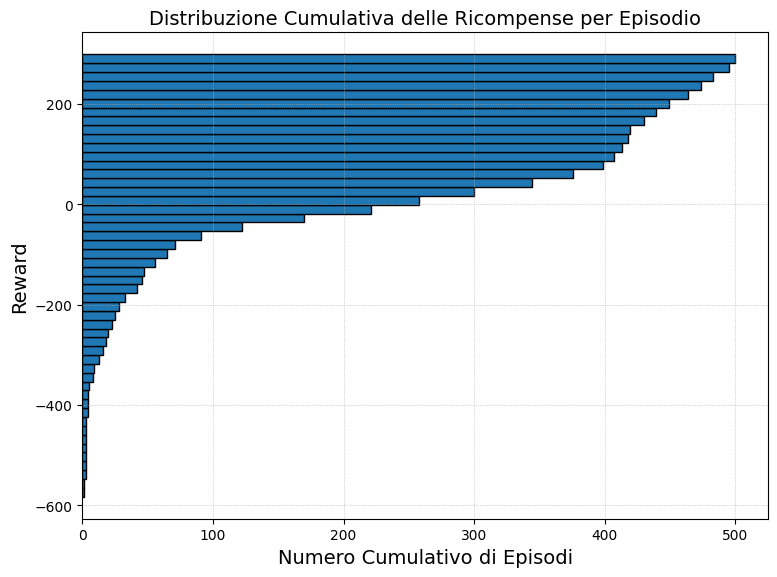

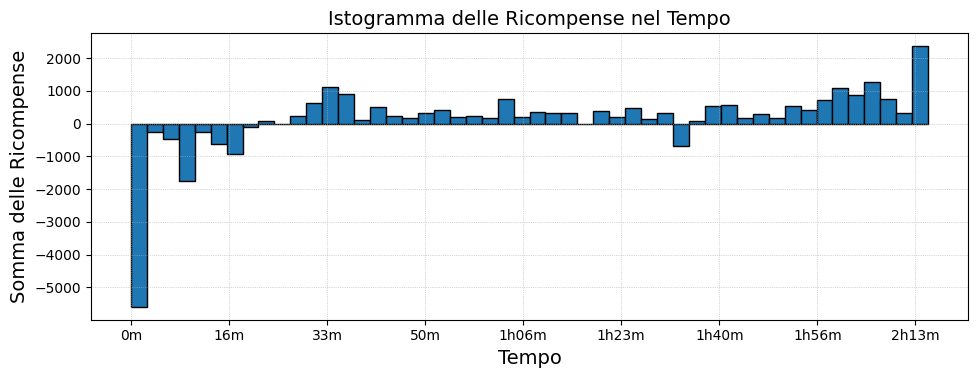

In [19]:

%matplotlib inline

#  Carico il CSV
df = pd.read_csv('/content/reward(penultimo modello).csv')

#  Rinomino colonne per comodità
df = df.rename(columns={
    'Episode': 'epoch',
    'TotalReward': 'reward',
    'CumulativeTime(s)': 'time_sec'
})
df['time_sec'] = df['time_sec'].astype(float)

#  Parametri generali
n_bins = 50

def format_time(x, pos):
    h = int(x // 3600)
    m = int((x % 3600) // 60)
    return f"{h}h{m:02d}m" if h > 0 else f"{m}m"

#  Istogramma cumulativo delle ricompense per episodio (orizzontale)
plt.figure(figsize=(8, 6))
plt.hist(
    df['reward'],
    bins=n_bins,
    orientation='horizontal',
    cumulative=True,
    edgecolor='black'
)
plt.xlabel('Numero Cumulativo di Episodi')
plt.ylabel('Reward')
plt.title('Distribuzione Cumulativa delle Ricompense per Episodio')
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# Istogramma: somma delle ricompense per time‐bin (verticale)
time = df['time_sec'].values
reward = df['reward'].values

# definisco bordi e centri dei bin sul tempo
bins = np.linspace(time.min(), time.max(), n_bins + 1)
centers = 0.5 * (bins[:-1] + bins[1:])

# somma reward in ciascun intervallo
sum_reward = np.array([
    reward[(time >= bins[i]) & (time < bins[i+1])].sum()
    for i in range(n_bins)
])

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(centers, sum_reward, width=(bins[1] - bins[0]), edgecolor='black')
ax.set_xlabel('Tempo')
ax.set_ylabel('Somma delle Ricompense')
ax.set_title('Istogramma delle Ricompense nel Tempo')
ax.xaxis.set_major_formatter(FuncFormatter(format_time))
ax.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


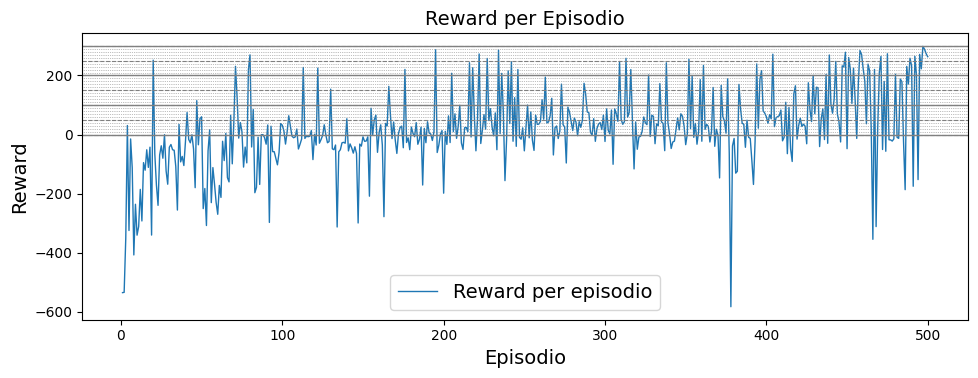

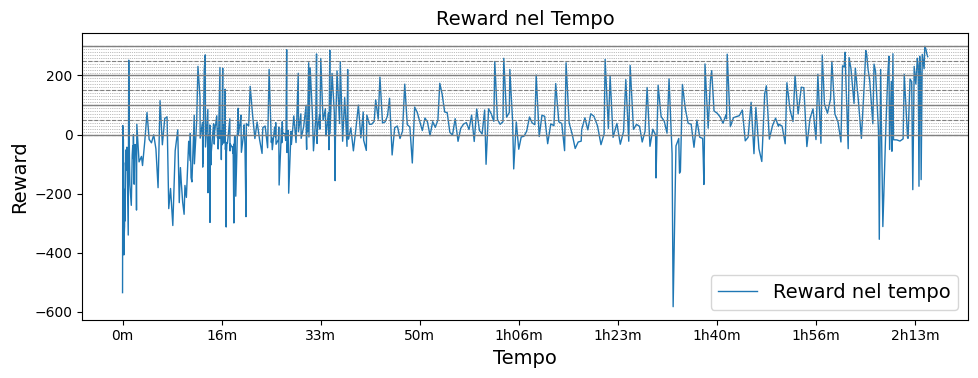

In [22]:

%matplotlib inline

#  Carico il CSV
df = pd.read_csv('/content/reward(penultimo modello).csv')

#  Rinomino le colonne per comodità
df = df.rename(columns={
    'Episode': 'epoch',
    'TotalReward': 'reward',
    'CumulativeTime(s)': 'time_sec'
})
df['time_sec'] = df['time_sec'].astype(float)

# Formatto per l’asse X del tempo (secondi -> Xm o HhMMm)
def format_time(x, pos):
    h = int(x // 3600)
    m = int((x % 3600) // 60)
    return f"{h}h{m:02d}m" if h > 0 else f"{m}m"

# Calcolo il massimo reward per le linee di riferimento
ymax = df['reward'].max()

#  Plot 1: Reward vs Episode
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['epoch'], df['reward'], lw=1, label='Reward per episodio')
ax.set_xlabel('Episodio')
ax.set_ylabel('Reward')
ax.set_title('Reward per Episodio')

# linee orizzontali ogni 10, 50, 100
for interval, style, lw in [(10, ':', 0.5), (50, '--', 0.8), (100, '-', 1)]:
    for y in range(0, int(ymax) + interval, interval):
        ax.axhline(y=y, color='grey', linestyle=style, linewidth=lw)

ax.legend()
plt.tight_layout()
plt.show()

#  Plot 2: Reward vs Tempo
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['time_sec'], df['reward'], lw=1, label='Reward nel tempo')
ax.set_xlabel('Tempo')
ax.set_ylabel('Reward')
ax.set_title('Reward nel Tempo')

# applico il formatto per secondi -> Xm/HhMMm
ax.xaxis.set_major_formatter(FuncFormatter(format_time))

# stesse righe orizzontali di riferimento
for interval, style, lw in [(10, ':', 0.5), (50, '--', 0.8), (100, '-', 1)]:
    for y in range(0, int(ymax) + interval, interval):
        ax.axhline(y=y, color='grey', linestyle=style, linewidth=lw)

ax.legend()
plt.tight_layout()
plt.show()


grafici con media:

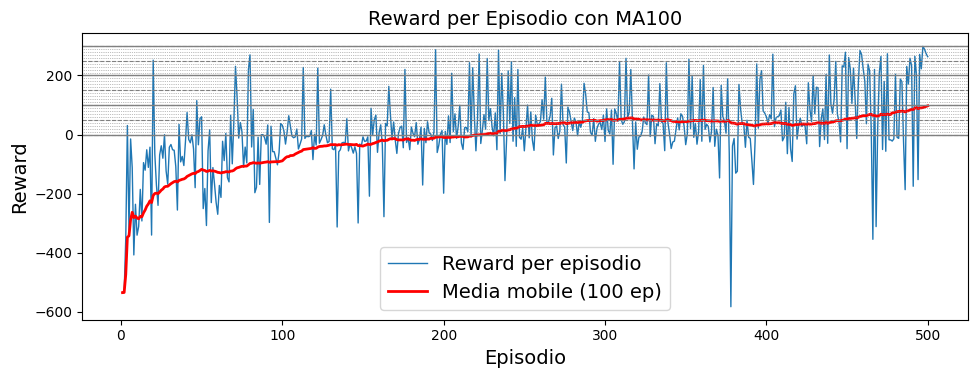

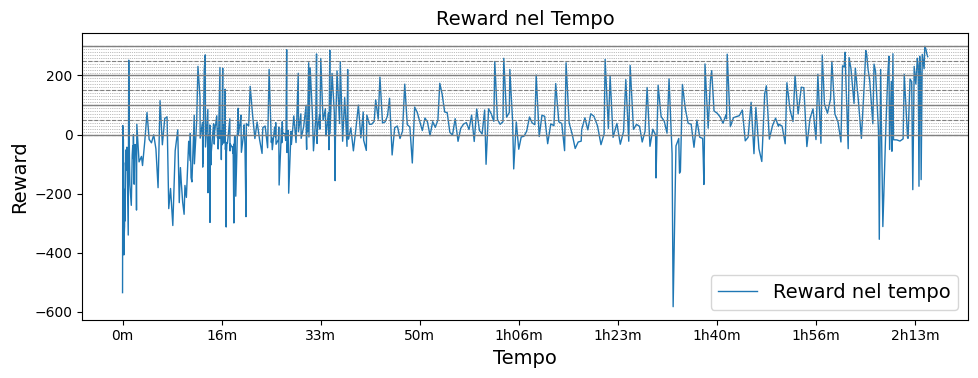

In [23]:

%matplotlib inline

#  Carico il CSV
df = pd.read_csv('/content/reward(penultimo modello).csv')

#  Rinomino le colonne per comodità
df = df.rename(columns={
    'Episode': 'epoch',
    'TotalReward': 'reward',
    'CumulativeTime(s)': 'time_sec'
})
df['time_sec'] = df['time_sec'].astype(float)

#  Calcolo la media mobile su 100 episodi
df['ma100'] = df['reward'].rolling(window=100, min_periods=1).mean()

#  Formatto per l’asse X del tempo (secondi -> Xm o HhMMm)
def format_time(x, pos):
    h = int(x // 3600)
    m = int((x % 3600) // 60)
    return f"{h}h{m:02d}m" if h > 0 else f"{m}m"

# Massimo reward per linee di riferimento
ymax = df['reward'].max()

# Plot 1: Reward vs Episodio + MA100
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['epoch'], df['reward'], lw=1, label='Reward per episodio')
ax.plot(df['epoch'], df['ma100'], lw=2, color='red', label='Media mobile (100 ep)')
ax.set_xlabel('Episodio')
ax.set_ylabel('Reward')
ax.set_title('Reward per Episodio con MA100')

# linee orizzontali di riferimento ogni 10, 50, 100 reward
for interval, style, lw in [(10, ':', 0.5), (50, '--', 0.8), (100, '-', 1)]:
    for y in range(0, int(ymax) + interval, interval):
        ax.axhline(y=y, color='grey', linestyle=style, linewidth=lw)

ax.legend()
plt.tight_layout()
plt.show()

#  Plot 2: Reward vs Tempo
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['time_sec'], df['reward'], lw=1, label='Reward nel tempo')
ax.set_xlabel('Tempo')
ax.set_ylabel('Reward')
ax.set_title('Reward nel Tempo')
ax.xaxis.set_major_formatter(FuncFormatter(format_time))

# stesse linee di riferimento
for interval, style, lw in [(10, ':', 0.5), (50, '--', 0.8), (100, '-', 1)]:
    for y in range(0, int(ymax) + interval, interval):
        ax.axhline(y=y, color='grey', linestyle=style, linewidth=lw)

ax.legend()
plt.tight_layout()
plt.show()


Parte con normalizzazione delle ricompense

In [7]:
# ===========================
#   modello con normalizzazione
# ===========================

import gym
import csv
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from collections import deque, namedtuple
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- RETI ---
class SoftQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, s, a):
        return self.net(torch.cat([s, a], dim=1))

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, log_std_min=-20, log_std_max=2):
        super().__init__()
        self.log_std_min, self.log_std_max = log_std_min, log_std_max
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU()
        )
        self.mean_layer   = nn.Linear(hidden_dim, action_dim)
        self.logstd_layer = nn.Linear(hidden_dim, action_dim)
    def forward(self, s):
        x = self.net(s)
        mean = self.mean_layer(x)
        logstd = torch.clamp(self.logstd_layer(x), self.log_std_min, self.log_std_max)
        return mean, logstd
    def sample(self, s):
        mean, logstd = self.forward(s)
        std = logstd.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()
        a = torch.tanh(x_t)
        logp = normal.log_prob(x_t) - torch.log(1 - a.pow(2) + 1e-6)
        return a, logp.sum(dim=1, keepdim=True)

# --- REPLAY BUFFER ---
class ReplayBuffer:
    def __init__(self, capacity=int(1e6)):
        self.buf = deque(maxlen=capacity)
        self.Exp = namedtuple("Exp", ["s","a","r","s2","d"])
    def add(self, s, a, r, s2, d):
        self.buf.append(self.Exp(
            np.array(s, dtype=np.float32),
            np.array(a, dtype=np.float32),
            float(r),
            np.array(s2, dtype=np.float32),
            bool(d)
        ))
    def sample(self, bs):
        ex = random.sample(self.buf, bs)
        # qui uso np.array per evitare warning
        s_arr  = np.array([e.s for e in ex], dtype=np.float32)
        a_arr  = np.array([e.a for e in ex], dtype=np.float32)
        s2_arr = np.array([e.s2 for e in ex], dtype=np.float32)
        r_arr  = np.array([[e.r] for e in ex], dtype=np.float32)
        d_arr  = np.array([[float(e.d)] for e in ex], dtype=np.float32)

        s  = torch.tensor(s_arr,  dtype=torch.float32, device=device)
        a  = torch.tensor(a_arr,  dtype=torch.float32, device=device)
        r  = torch.tensor(r_arr,  dtype=torch.float32, device=device)
        s2 = torch.tensor(s2_arr, dtype=torch.float32, device=device)
        d  = torch.tensor(d_arr,  dtype=torch.float32, device=device)
        return s, a, r, s2, d

    def __len__(self):
        return len(self.buf)

#  SAC AGENT con reward-normalizzate e policy_delay=2 (aggiornamento ogni 2)
class SACAgent:
    def __init__(self, state_dim, action_dim, action_bounds,
                 gamma=0.99, tau=0.005, lr=3e-4, policy_delay=2):
        self.low, self.high = action_bounds
        # reti
        self.q1      = SoftQNetwork(state_dim, action_dim).to(device)
        self.q2      = SoftQNetwork(state_dim, action_dim).to(device)
        self.q1_tgt  = SoftQNetwork(state_dim, action_dim).to(device)
        self.q2_tgt  = SoftQNetwork(state_dim, action_dim).to(device)
        self.policy  = PolicyNetwork(state_dim, action_dim).to(device)
        # inizializza target
        self.q1_tgt.load_state_dict(self.q1.state_dict())
        self.q2_tgt.load_state_dict(self.q2.state_dict())
        # ottimizzatori
        self.q1_opt     = optim.Adam(self.q1.parameters(),     lr=lr)
        self.q2_opt     = optim.Adam(self.q2.parameters(),     lr=lr)
        self.policy_opt = optim.Adam(self.policy.parameters(), lr=lr)
        self.log_alpha  = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_opt  = optim.Adam([self.log_alpha],        lr=lr)
        self.alpha      = self.log_alpha.exp()
        # iperparametri
        self.gamma, self.tau    = gamma, tau
        self.target_entropy     = -action_dim
        self.replay_buffer      = ReplayBuffer()
        self.policy_delay       = policy_delay
        self._upd_steps         = 0
        # statistiche per normalizzazione reward
        self._r_count = 0
        self._r_mean  = 0.0
        self._r_M2    = 0.0

    def _update_reward_stats(self, r: float):
        self._r_count += 1
        delta = r - self._r_mean
        self._r_mean += delta / self._r_count
        self._r_M2   += delta * (r - self._r_mean)

    def _normalize_reward(self, r: float):
        if self._r_count < 2:
            return r
        std = np.sqrt(self._r_M2 / (self._r_count - 1)) + 1e-6
        return (r - self._r_mean) / std

    def act(self, state, deterministic=False):
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            mean, logstd = self.policy(s)
            std = logstd.exp()
            dist = Normal(mean, std)
            x_t = mean if deterministic else dist.sample()
            a = torch.tanh(x_t)
        a = a.cpu().numpy()[0]
        return ((a + 1) / 2 * (self.high - self.low) + self.low).astype(np.float32)

    def update(self, batch_size=256):
        if len(self.replay_buffer) < batch_size:
            return

        s, a, r, s2, d = self.replay_buffer.sample(batch_size)
        # critic update ogni step
        with torch.no_grad():
            a2, logp2 = self.policy.sample(s2)
            q1n = self.q1_tgt(s2, a2)
            q2n = self.q2_tgt(s2, a2)
            qn  = torch.min(q1n, q2n) - self.alpha * logp2
            y   = r + (1 - d) * self.gamma * qn

        q1 = self.q1(s, a); q2 = self.q2(s, a)
        loss_q1 = F.mse_loss(q1, y); loss_q2 = F.mse_loss(q2, y)
        self.q1_opt.zero_grad(); loss_q1.backward(); self.q1_opt.step()
        self.q2_opt.zero_grad(); loss_q2.backward(); self.q2_opt.step()

        self._upd_steps += 1
        # policy e alpha update ogni policy_delay (decadimento policy) critic‐updates
        if self._upd_steps % self.policy_delay == 0:
            a_new, logp_new = self.policy.sample(s)
            q_pi    = torch.min(self.q1(s, a_new), self.q2(s, a_new))
            loss_pi = (self.alpha * logp_new - q_pi).mean()
            loss_a  = -(self.log_alpha * (logp_new + self.target_entropy).detach()).mean()

            self.policy_opt.zero_grad(); loss_pi.backward();    self.policy_opt.step()
            self.alpha_opt.zero_grad();  loss_a.backward();     self.alpha_opt.step()
            self.alpha = self.log_alpha.exp()

            # soft update target Q
            for tgt, src in zip(self.q1_tgt.parameters(), self.q1.parameters()):
                tgt.data.copy_(self.tau * src.data + (1 - self.tau) * tgt.data)
            for tgt, src in zip(self.q2_tgt.parameters(), self.q2.parameters()):
                tgt.data.copy_(self.tau * src.data + (1 - self.tau) * tgt.data)

# ========== TRAINING LOOP ==========
env = gym.make("LunarLanderContinuous-v2", new_step_api=True)
obs = env.reset()
state = obs[0] if isinstance(obs, tuple) else obs

obs_dim = state.shape[0]
act_dim = env.action_space.shape[0]
agent = SACAgent(obs_dim, act_dim, (env.action_space.low, env.action_space.high))

num_episodes = 500
batch_size    = 256
csv_file      = "rewards_with_time_norm.csv"
if os.path.exists(csv_file): os.remove(csv_file)
with open(csv_file, "w", newline="") as f:
    csv.writer(f).writerow(["Episode","TotalReward","TimeEp(s)","CumTime(s)","Alpha"])

start_time = time.time()
for ep in range(1, num_episodes+1):
    ep_start = time.time()
    obs = env.reset()
    state = obs[0] if isinstance(obs, tuple) else obs
    total_r = 0.0
    done = False

    while not done:
        action = agent.act(state)
        step = env.step(action)
        if len(step) == 5:
            next_s, reward, term, trunc, info = step
            done = term or trunc
        else:
            next_s, reward, done, info = step

        # aggiorno stats e normalizzo reward
        agent._update_reward_stats(reward)
        r_norm = agent._normalize_reward(reward)
        agent.replay_buffer.add(state, action, r_norm, next_s, done)

        state = next_s
        total_r += reward
        agent.update(batch_size)

    ep_time  = time.time() - ep_start
    cum_time = time.time() - start_time
    alpha_val = agent.alpha.item()
    # salvo anche alpha
    with open(csv_file, "a", newline="") as f:
        csv.writer(f).writerow([ep, round(total_r,2), round(ep_time,2),
                                round(cum_time,2), round(alpha_val,4)])

    # print reward + alpha
    print(f"Episode {ep}/{num_episodes} | Reward: {total_r:.2f} | α: {alpha_val:.4f}")
    if ep % 10 == 0:
        data = np.loadtxt(csv_file, delimiter=",", skiprows=1)
        print(f">>> Avg(last10) {data[-10:,1].mean():.2f},  Avg α(last10) {data[-10:,4].mean():.4f}")

print("Training completato.")


Episode 1/500 | Reward: -115.68 | α: 1.0000
Episode 2/500 | Reward: -164.46 | α: 0.9988
Episode 3/500 | Reward: -412.80 | α: 0.9845
Episode 4/500 | Reward: -74.71 | α: 0.9677
Episode 5/500 | Reward: -552.99 | α: 0.9387
Episode 6/500 | Reward: -71.61 | α: 0.9283
Episode 7/500 | Reward: -162.63 | α: 0.9148
Episode 8/500 | Reward: -525.34 | α: 0.8952
Episode 9/500 | Reward: -178.52 | α: 0.8805
Episode 10/500 | Reward: -29.43 | α: 0.8633
>>> Avg(last10) -228.82,  Avg α(last10) 0.9372
Episode 11/500 | Reward: -332.50 | α: 0.8459
Episode 12/500 | Reward: -217.93 | α: 0.8336
Episode 13/500 | Reward: -125.81 | α: 0.8136
Episode 14/500 | Reward: -156.88 | α: 0.7948
Episode 15/500 | Reward: -255.33 | α: 0.7781
Episode 16/500 | Reward: -58.32 | α: 0.7640
Episode 17/500 | Reward: -349.63 | α: 0.7495
Episode 18/500 | Reward: -111.81 | α: 0.7351
Episode 19/500 | Reward: -65.97 | α: 0.7156
Episode 20/500 | Reward: -347.37 | α: 0.7016
>>> Avg(last10) -202.16,  Avg α(last10) 0.7732
Episode 21/500 | Rew

Adesso facciamo i grafici del file csv per comprendere andamento rumore e verificare la bontà del modello, vedendo il print delle ricompense il modello sembra abbastanza rumoroso

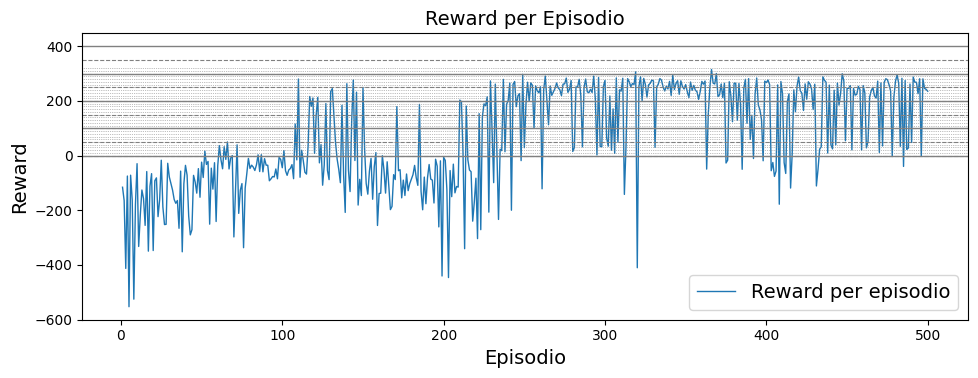

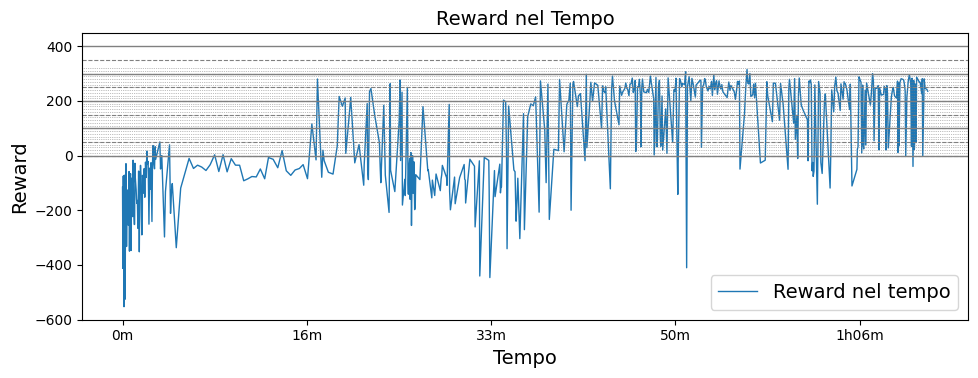

In [10]:
# Colab: installazione (se serve)
# !pip install pandas matplotlib

%matplotlib inline

# 1) Carico il CSV
df = pd.read_csv('/content/rewards_with_time_norm-2.csv')

# 2) Rinomino le colonne per comodità
df = df.rename(columns={
    'Episode': 'epoch',
    'TotalReward': 'reward',
    'CumTime(s)': 'time_sec'
})

# Assicuro che time_sec sia float
df['time_sec'] = df['time_sec'].astype(float)

# 3) Formatto per l’asse X del tempo (secondi -> Xm o XhYm)
def format_time(x, pos):
    h = int(x // 3600)
    m = int((x % 3600) // 60)
    if h > 0:
        return f"{h}h{m:02d}m"
    else:
        return f"{m}m"

# Calcolo il massimo reward per le linee di riferimento
ymax = df['reward'].max()

# 4) Plot 1: Reward vs Episode
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['epoch'], df['reward'], lw=1, label='Reward per episodio')
ax.set_xlabel('Episodio')
ax.set_ylabel('Reward')
ax.set_title('Reward per Episodio')

# linee orizzontali ogni 10, 50, 100
for interval, style, lw in [(10, ':', 0.5), (50, '--', 0.8), (100, '-', 1)]:
    for y in range(0, int(ymax) + interval, interval):
        ax.axhline(y=y, color='grey', linestyle=style, linewidth=lw)

ax.legend()
plt.tight_layout()
plt.show()

# 5) Plot 2: Reward vs Tempo
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['time_sec'], df['reward'], lw=1, label='Reward nel tempo')
ax.set_xlabel('Tempo')
ax.set_ylabel('Reward')
ax.set_title('Reward nel Tempo')

# uso il formatto per secondi -> minuti/ore
ax.xaxis.set_major_formatter(FuncFormatter(format_time))

# stesse righe orizzontali di riferimento
for interval, style, lw in [(10, ':', 0.5), (50, '--', 0.8), (100, '-', 1)]:
    for y in range(0, int(ymax) + interval, interval):
        ax.axhline(y=y, color='grey', linestyle=style, linewidth=lw)

ax.legend()
plt.tight_layout()
plt.show()


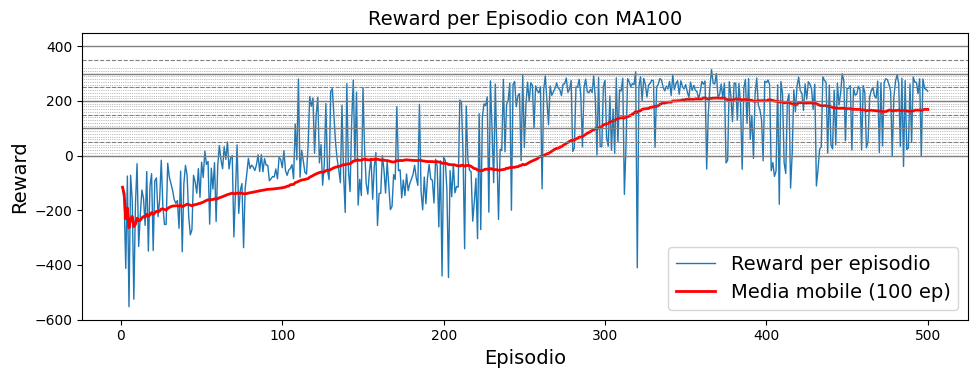

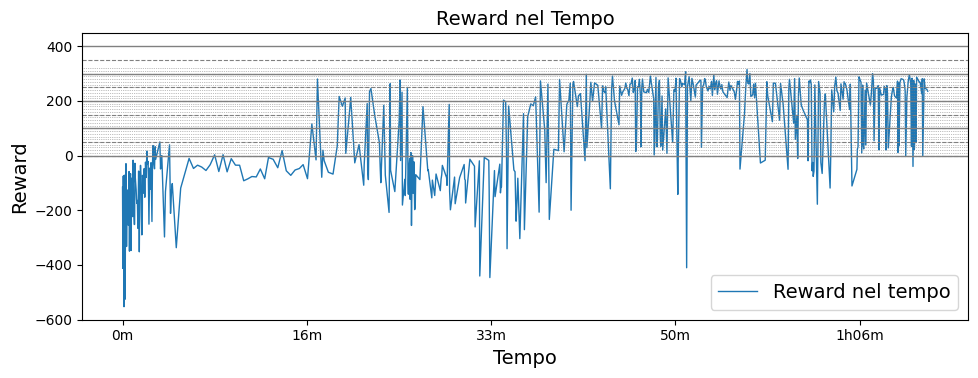

In [25]:

%matplotlib inline


#  Carico il CSV
df = pd.read_csv('/content/rewards_with_time_norm-2.csv')

#  Rinomino le colonne per comodità
df = df.rename(columns={
    'Episode': 'epoch',
    'TotalReward': 'reward',
    'CumTime(s)': 'time_sec'   # <— qui
})
# Assicuro che time_sec sia float
df['time_sec'] = df['time_sec'].astype(float)

# 3) Calcola media mobile su 100 episodi
df['ma100'] = df['reward'].rolling(window=100, min_periods=1).mean()

# 4) Formatto per l’asse X del tempo (secondi -> Xm o HhMMm)
def format_time(x, pos):
    h = int(x // 3600)
    m = int((x % 3600) // 60)
    return f"{h}h{m:02d}m" if h > 0 else f"{m}m"

# Massimo reward per le linee di riferimento
ymax = df['reward'].max()

#  Plot 1: Reward vs Episodio + MA100 (media  ogni 100)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['epoch'], df['reward'], lw=1, label='Reward per episodio')
ax.plot(df['epoch'], df['ma100'], lw=2, color='red', label='Media mobile (100 ep)')
ax.set_xlabel('Episodio')
ax.set_ylabel('Reward')
ax.set_title('Reward per Episodio con MA100')

# linee orizzontali di riferimento ogni 10, 50, 100 reward
for interval, style, lw in [(10, ':', 0.5), (50, '--', 0.8), (100, '-', 1)]:
    for y in range(0, int(ymax) + interval, interval):
        ax.axhline(y=y, color='grey', linestyle=style, linewidth=lw)

ax.legend()
plt.tight_layout()
plt.show()

# Plot 2: Reward vs Tempo
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['time_sec'], df['reward'], lw=1, label='Reward nel tempo')
ax.set_xlabel('Tempo')
ax.set_ylabel('Reward')
ax.set_title('Reward nel Tempo')
ax.xaxis.set_major_formatter(FuncFormatter(format_time))

# stesse linee di riferimento
for interval, style, lw in [(10, ':', 0.5), (50, '--', 0.8), (100, '-', 1)]:
    for y in range(0, int(ymax) + interval, interval):
        ax.axhline(y=y, color='grey', linestyle=style, linewidth=lw)

ax.legend()
plt.tight_layout()
plt.show()


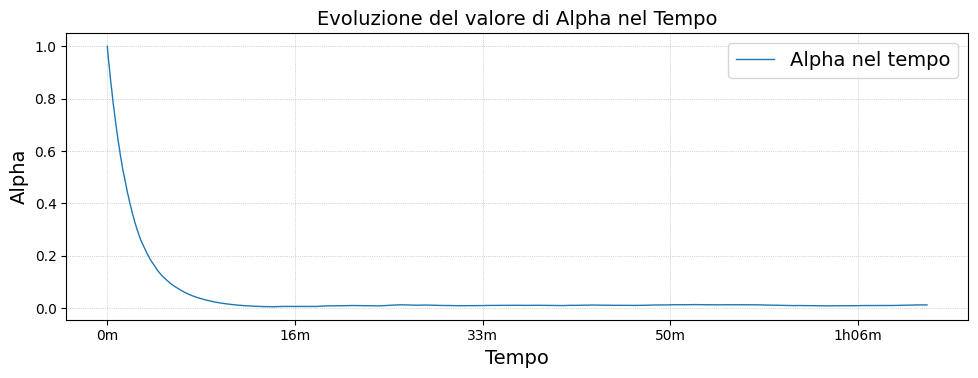

In [11]:
%matplotlib inline

#  Se non ho già la funzione, ridefinisco il formatto tempo: Xm/HhMMm
def format_time(x, pos):
    h = int(x // 3600)
    m = int((x % 3600) // 60)
    if h > 0:
        return f"{h}h{m:02d}m"
    else:
        return f"{m}m"

#  Plot Alpha vs Time
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['time_sec'], df['Alpha'], lw=1, label='Alpha nel tempo')
ax.set_xlabel('Tempo')
ax.set_ylabel('Alpha')
ax.set_title('Evoluzione del valore di Alpha nel Tempo')

# formatto l'asse X
ax.xaxis.set_major_formatter(FuncFormatter(format_time))

ax.grid(True, linestyle=':', linewidth=0.5)

ax.legend()
plt.tight_layout()
plt.show()


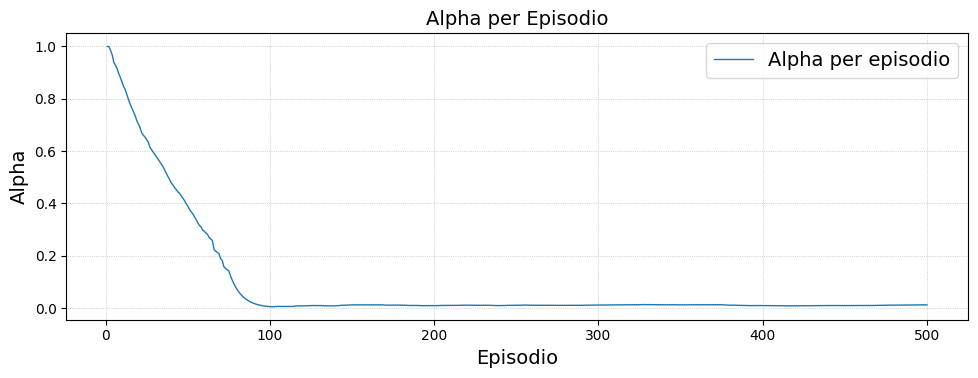

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot Alpha vs Episode
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df['epoch'], df['Alpha'], lw=1, label='Alpha per episodio')
ax.set_xlabel('Episodio')
ax.set_ylabel('Alpha')
ax.set_title('Alpha per Episodio')

# aggiungo griglia leggera
ax.grid(True, linestyle=':', linewidth=0.5)

ax.legend()
plt.tight_layout()
plt.show()


Cerco di capire come si distribuiscono le ricompense

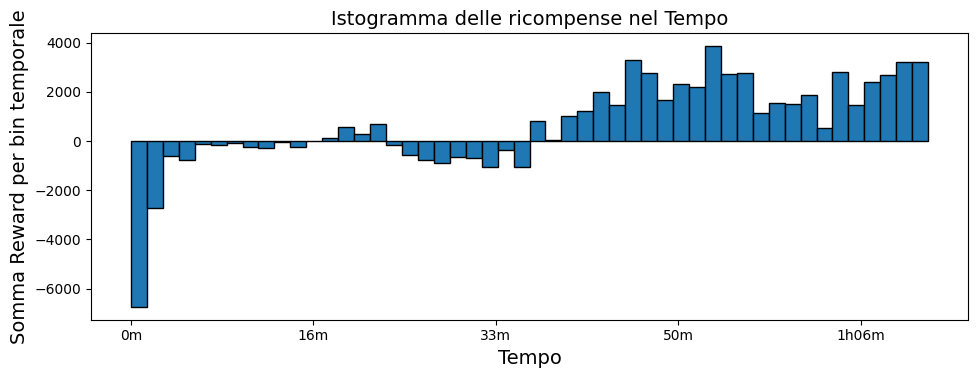

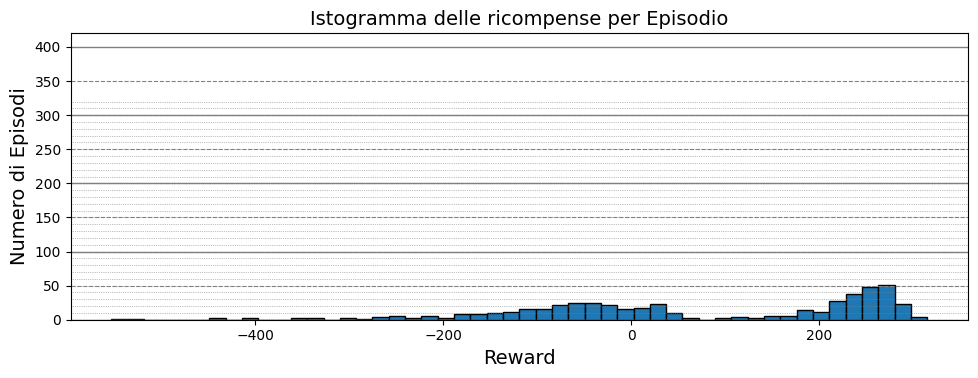

In [13]:
%matplotlib inline


# Calcolo il massimo reward (per coerenza con i plot precedenti)
ymax = df['reward'].max()

# Istogramma: distribuzione delle ricompense nel tempo
fig, ax = plt.subplots(figsize=(10, 4))
# bins: puoi cambiare il numero a piacere
n_bins = 50
# pesiamo ogni “evento” con la ricompensa per vedere quanti punti-reward cadono in ciascun intervallo temporale
ax.hist(df['time_sec'], bins=n_bins, weights=df['reward'], edgecolor='black')
ax.set_xlabel('Tempo')
ax.set_ylabel('Somma Reward per bin temporale')
ax.set_title('Istogramma delle ricompense nel Tempo')
# riutilizziamo il formatto per secondi
def format_time(x, pos):
    h = int(x // 3600)
    m = int((x % 3600) // 60)
    return f"{h}h{m:02d}m" if h>0 else f"{m}m"
ax.xaxis.set_major_formatter(FuncFormatter(format_time))
plt.tight_layout()
plt.show()

# Istogramma: distribuzione delle ricompense per episodio
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(df['reward'], bins=n_bins, edgecolor='black')
ax.set_xlabel('Reward')
ax.set_ylabel('Numero di Episodi')
ax.set_title('Istogramma delle ricompense per Episodio')
# righe di riferimento
for interval, style, lw in [(10, ':', 0.5), (50, '--', 0.8), (100, '-', 1)]:
    for y in range(0, int(ymax) + interval, interval):
        ax.axhline(y=y, color='grey', linestyle=style, linewidth=lw)
plt.tight_layout()
plt.show()


📁 Seleziona il tuo CSV e clicca OK


Saving rewards_with_time_norm-2.csv to rewards_with_time_norm-2 (1).csv


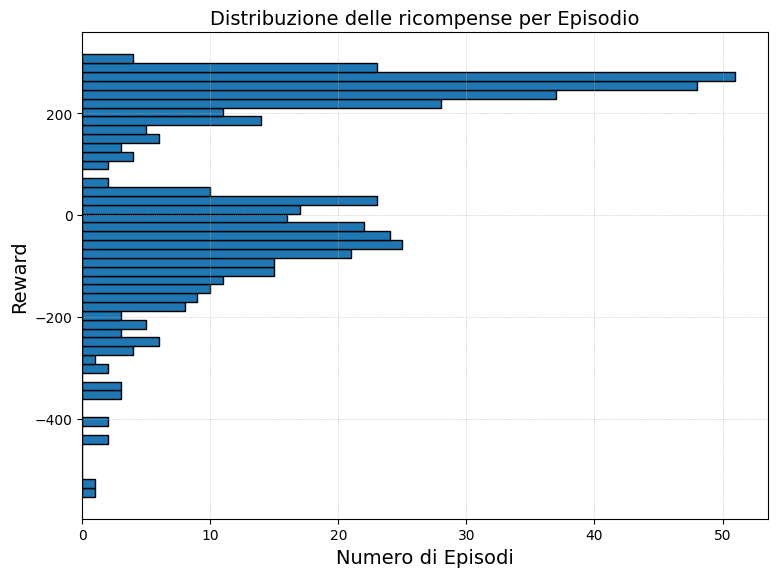

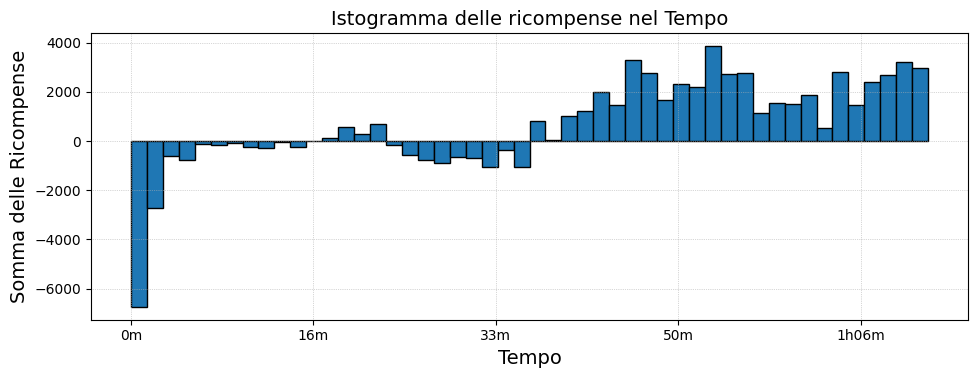

In [15]:

%matplotlib inline
from google.colab import files


#  upload del file
print(" Seleziona il tuo CSV e clicca OK")
uploaded = files.upload()                # si apre un file‐picker
fname = next(iter(uploaded.keys()))      # prende il primo file caricato
df = pd.read_csv(io.BytesIO(uploaded[fname]))

#  rinomina colonne
df = df.rename(columns={
    'Episode': 'epoch',
    'TotalReward': 'reward',
    'CumTime(s)': 'time_sec'
})
df['time_sec'] = df['time_sec'].astype(float)

# parametri comuni
n_bins = 50
def format_time(x, pos):
    h = int(x // 3600)
    m = int((x % 3600) // 60)
    return f"{h}h{m:02d}m" if h>0 else f"{m}m"

#  Istogramma distribuzione reward per episodio (orizzontale)
plt.figure(figsize=(8,6))
plt.hist(df['reward'], bins=n_bins, orientation='horizontal', edgecolor='black')
plt.xlabel('Numero di Episodi')
plt.ylabel('Reward')
plt.title('Distribuzione delle ricompense per Episodio')
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

#  Istogramma somma delle reward per time‐bin (verticale)
time = df['time_sec'].values
reward = df['reward'].values
bins = np.linspace(time.min(), time.max(), n_bins+1)
centers = 0.5*(bins[:-1]+bins[1:])
sum_reward = np.array([
    reward[(time>=bins[i]) & (time<bins[i+1])].sum()
    for i in range(n_bins)
])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(centers, sum_reward, width=(bins[1]-bins[0]), edgecolor='black')
ax.set_xlabel('Tempo')
ax.set_ylabel('Somma delle Ricompense')
ax.set_title('Istogramma delle ricompense nel Tempo')
ax.xaxis.set_major_formatter(FuncFormatter(format_time))
ax.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


 Seleziona il tuo CSV e clicca OK


Saving rewards_with_time_norm-2.csv to rewards_with_time_norm-2 (3).csv


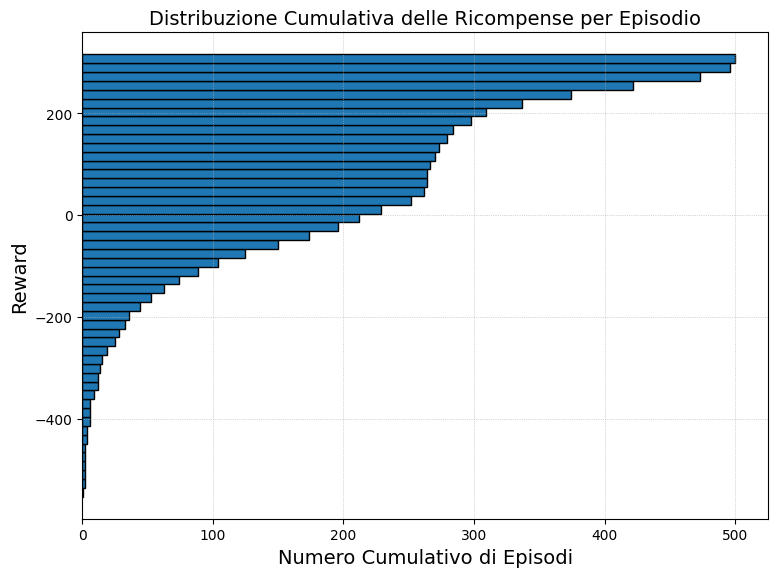

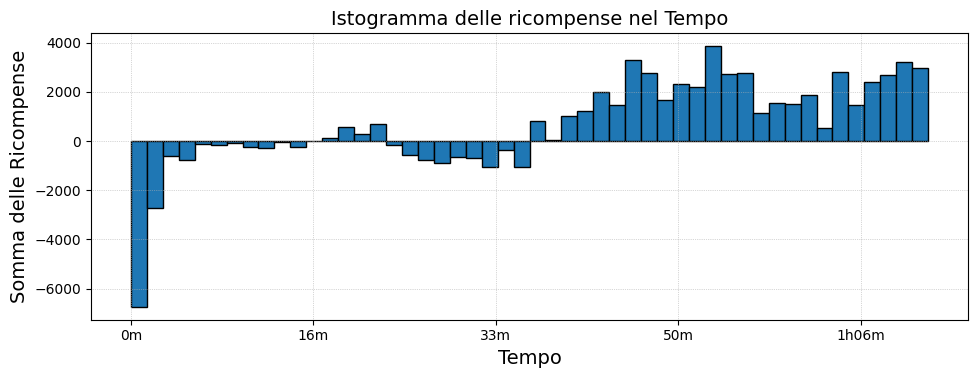

In [17]:

%matplotlib inline
from google.colab import files

#  Upload del CSV
print(" Seleziona il tuo CSV e clicca OK")
uploaded = files.upload()
fname = next(iter(uploaded.keys()))
df = pd.read_csv(io.BytesIO(uploaded[fname]))

#  Rinomina colonne per comodità
df = df.rename(columns={
    'Episode': 'epoch',
    'TotalReward': 'reward',
    'CumTime(s)': 'time_sec'
})
df['time_sec'] = df['time_sec'].astype(float)

#  Parametri generali
n_bins = 50
def format_time(x, pos):
    h = int(x // 3600)
    m = int((x % 3600) // 60)
    return f"{h}h{m:02d}m" if h>0 else f"{m}m"

#  Istogramma "CUMULATIVO" delle ricompense per Episodio
plt.figure(figsize=(8,6))
plt.hist(
    df['reward'],
    bins=n_bins,
    orientation='horizontal',
    cumulative=True,
    edgecolor='black'
)
plt.xlabel('Numero Cumulativo di Episodi')
plt.ylabel('Reward')
plt.title('Distribuzione Cumulativa delle Ricompense per Episodio')
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

#  Istogramma somma delle ricompense per time‐bin (y)
time = df['time_sec'].values
reward = df['reward'].values
bins = np.linspace(time.min(), time.max(), n_bins+1)
centers = 0.5 * (bins[:-1] + bins[1:])
sum_reward = np.array([
    reward[(time>=bins[i]) & (time<bins[i+1])].sum()
    for i in range(n_bins)
])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(centers, sum_reward, width=(bins[1]-bins[0]), edgecolor='black')
ax.set_xlabel('Tempo')
ax.set_ylabel('Somma delle Ricompense')
ax.set_title('Istogramma delle ricompense nel Tempo')
ax.xaxis.set_major_formatter(FuncFormatter(format_time))
ax.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()
